<a href="https://colab.research.google.com/github/jdehning/corona_forecast/blob/master/Corona_germany.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

confirmed_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
confirmed_cases = pd.read_csv(confirmed_cases_url, sep=',')
deaths_url = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
deaths = pd.read_csv(deaths_url, sep=',')
confirmed_cases

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,14,14,14,19,19,19,19,25,25,25,25,32,32,32,33,33,33,33,33,34,35,35,35,35,35,35,35,35,37,40,40,41,42,42,43,43,43,47,48,50,50,50,53,59,70,75,82,114,147,177,212,272,322
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,7,7,11,15,20,20,20,22,22,45,25,25,26,26,26,28,28,29,43,59,66,74,84,94,105,122,147,159,170,189,214,228,241,256,274,293,331,360,420,461,502,511,581,639,639,701,773,839,825,878,889,924,963
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,7,7,10,13,16,18,18,24,28,28,30,33,40,45,47,50,58,67,72,75,77,81,84,84,85,85,89,89,91,93,93,93,102,106,108,110,110,117,130,138,150,150,160,178,178,200,212,226,243,266,313,345,385
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,4,7,8,8,8,8,8,10,12,12,12,16,16,18,18,18,19,19,22,22,22,22,22,22,22,22,22,22,22,22,23,23,25,29,29,36,50,50,83,93,99,117,129,149,149,197,238,428,566,673,790,900,1030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472,Sint Maarten,Netherlands,18.0425,-63.0548,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
473,NaN,Niger,17.6078,8.0817,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
474,NaN,Papua New Guinea,-6.3150,143.9555,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
475,Isle of Man,United Kingdom,54.2361,-4.5481,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [70]:
import pymc3 as pm
import theano.tensor as tt
import datetime


cases_obs = np.array(
    confirmed_cases.loc[confirmed_cases["Country/Region"] == "Germany", "3/6/20":]
)[0]
date_today = confirmed_cases.loc[confirmed_cases["Country/Region"] == "Germany", "3/6/20":].columns[-1]
month, year, day = map(int,date_today.split('/'))
date_today = datetime.date(year+2000, month, day)
print('Cases today ({}): {} and yesterday: {}'.format(date_today.isoformat(), *cases_obs[:-3:-1]))
deaths_obs = np.array(deaths.loc[deaths["Country/Region"] == "Germany", "3/6/20":])[0]
num_days = len(cases_obs)
num_days_to_predict = 28
np.random.seed(0)

# ------------------------------------------------------------------------------ #
# model setup and training
# ------------------------------------------------------------------------------ #

with pm.Model() as model:
    # true cases at begin of loaded data but we do not know the real number
    num_cases_at_0 = pm.HalfCauchy("num_cases_at_0", beta=1000)

    # fraction of people that are newly infected each day
    m = pm.Uniform("m", lower=0.1, upper=0.8)

    # factor of sick people being recorded
    subs_factor = pm.Normal("subs_factor", mu=0.7, sigma=0.1)

    # fraction of people that recover each day, recovery rate mu
    mu = 1/8

    # prior of the error of observed cases
    sigma_obs = pm.HalfCauchy("prior_sigma_obs", beta=1)

    # training the model with loaded data
    for i_day in range(0, num_days):
        if i_day == 0:
            # create the time series, initially length one
            active_cases = [num_cases_at_0]
            cumulative_cases = active_cases[-1]
        else:
            new_cases = m * active_cases[-1]
            recovered_cases = mu * active_cases[-1]
            active_cases.append(active_cases[-1] + new_cases - recovered_cases)
            cumulative_cases += new_cases

        # needed for pymc3
        # pm.Deterministic links variables to computational graph
        pm.Deterministic("active_cases_{}".format(i_day), active_cases[i_day])
        cumulative_cases = pm.Deterministic(
            "cum_cases_{}".format(i_day), cumulative_cases
        )

        # Approximates Poisson
        # calculate the likelihood of the model:
        # observed cases are distributed following studentT around the model
        pm.StudentT(
            "obs_{}".format(i_day),
            nu=4,
            mu=cumulative_cases * subs_factor,
            observed=cases_obs[i_day],
            sigma=(cumulative_cases * subs_factor) ** 0.5 * sigma_obs,
        )

    # ------------------------------------------------------------------------------ #
    # prediction, start with no changes in policy
    # ------------------------------------------------------------------------------ #
    
    # delay in days between contracting the disease and being recorded
    delay = pm.Normal("delay", mu=8, sigma=1.5)

    active_cases_pred_no_change = []

    # increase error of future m, on top of fit uncertainty
    error_m = pm.Normal("error_m", mu=0, sigma=0.02)

    # local copy of original fitted values
    cumulative = cumulative_cases

    for i_day in range(0, num_days_to_predict):
        if i_day == 0:
            active_cases_bef = active_cases[-1]
        else:
            active_cases_bef = active_cases_pred_no_change[-1]

        # update cases
        new_cases = active_cases_bef * (m + error_m)

        recovered_cases = active_cases_bef * mu
        active_cases_pred_no_change.append(
            active_cases_bef + new_cases - recovered_cases
        )

        # update variables (in computational graph, too.)
        pm.Deterministic(
            "active_cases_predict_no_change_{}".format(i_day),
            active_cases_pred_no_change[i_day],
        )
        cumulative = pm.Deterministic(
            "cum_cases_no_change_{}".format(i_day), cumulative + new_cases
        )
        pm.Deterministic(
            "meas_predict_no_change_{}".format(i_day), cumulative * subs_factor
        )

    # ------------------------------------------------------------------------------ #
    # social distancing, m reduced by about 50 percent
    # ------------------------------------------------------------------------------ #

    # m is decreased by approximately 50%
    reduction_fact_mild = 0.5

    decrease_in = 7  # days
    days_offset = 0  # start the decrease in spreading rate after this

    time = np.arange(num_days_to_predict)
    cumulative = cumulative_cases
    active_cases_pred_social_distancing = []

    # change in m along time
    m_correction = tt.clip((time - delay - days_offset + 1) / decrease_in, 0, 1)

    for i_day in range(0, num_days_to_predict):
        if i_day == 0:
            active_cases_bef = active_cases[-1]
        else:
            active_cases_bef = active_cases_pred_social_distancing[-1]

        # update cases
        new_cases = active_cases_bef * (m * (1 - m_correction[i_day] * reduction_fact_mild) + error_m)

        recovered_cases = active_cases_bef * mu
        active_cases_pred_social_distancing.append(
            active_cases_bef + new_cases - recovered_cases
        )

        # update variables (in computational graph, too.)
        pm.Deterministic(
            "active_cases_predict_social_distancing_{}".format(i_day),
            active_cases_pred_social_distancing[i_day],
        )
        cumulative = pm.Deterministic(
            "cum_cases_social_distancing_{}".format(i_day), cumulative + new_cases
        )
        pm.Deterministic(
            "meas_predict_social_distancing_{}".format(i_day), cumulative * subs_factor
        )

    # ------------------------------------------------------------------------------ #
    # isolation, almost no new cases besides baseline after transient phase
    # ------------------------------------------------------------------------------ #

    decrease_in = 7  # days
    days_offset = 0  # start the decrease in spreading rate after this

    # spreading of people who transmit although they are isolated

    time = np.arange(num_days_to_predict)
    cumulative = cumulative_cases
    active_cases_pred_isolation = []

    reduction_fact_strong = 0.9


    # change in m along time
    m_correction = tt.clip((time - delay - days_offset + 1) / decrease_in, 0, 1)

    for i_day in range(0, num_days_to_predict):
        if i_day == 0:
            active_cases_bef = active_cases[-1]
        else:
            active_cases_bef = active_cases_pred_isolation[-1]

        # update cases
        new_cases = active_cases_bef * ((m * (1 - m_correction[i_day] * reduction_fact_strong) + error_m))

        recovered_cases = active_cases_bef * mu
        active_cases_pred_isolation.append(
            active_cases_bef + new_cases - recovered_cases
        )

        # update variables (in computational graph, too.)
        pm.Deterministic(
            "active_cases_predict_isolation_{}".format(i_day),
            active_cases_pred_isolation[i_day],
        )
        cumulative = pm.Deterministic(
            "cum_cases_isolation_{}".format(i_day), cumulative + new_cases
        )
        pm.Deterministic(
            "meas_predict_isolation_{}".format(i_day), cumulative * subs_factor
        )

    # ------------------------------------------------------------------------------ #
    # isolation 5 days later, almost no new cases besides baseline after transient phase
    # ------------------------------------------------------------------------------ #

    decrease_in = 7  # days
    days_offset = 5  # start the decrease in spreading rate after this

    time = np.arange(num_days_to_predict)
    cumulative = cumulative_cases
    active_cases_pred_isolation_late = []

    # change in m along time
    m_correction = tt.clip((time - delay - days_offset + 1) / decrease_in, 0, 1)

    for i_day in range(0, num_days_to_predict):
        if i_day == 0:
            active_cases_bef = active_cases[-1]
        else:
            active_cases_bef = active_cases_pred_isolation_late[-1]

        # update cases
        new_cases = active_cases_bef * ((m * (1 - m_correction[i_day] * reduction_fact_strong) + error_m))

        recovered_cases = active_cases_bef * mu
        active_cases_pred_isolation_late.append(
            active_cases_bef + new_cases - recovered_cases
        )

        # update variables (in computational graph, too.)
        pm.Deterministic(
            "active_cases_predict_isolation_late_{}".format(i_day),
            active_cases_pred_isolation_late[i_day]
        )
        cumulative = pm.Deterministic(
            "cum_cases_isolation_late_{}".format(i_day), cumulative + new_cases
        )
        pm.Deterministic(
            "meas_predict_isolation_late_{}".format(i_day), cumulative * subs_factor
        )

    # ------------------------------------------------------------------------------ #
    # run model, pm trains and predicts when calling this
    # ------------------------------------------------------------------------------ #

    trace = pm.sample(draws=500, chains=2)

Cases today (2020-03-20): 19848 and yesterday: 15320


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [error_m, delay, prior_sigma_obs, subs_factor, m, num_cases_at_0]
100%|██████████| 1000/1000 [00:24<00:00, 40.31it/s]


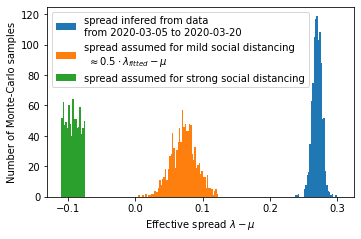

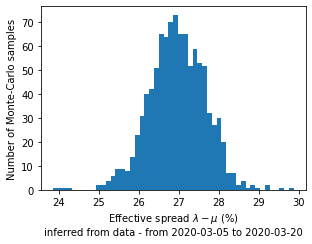

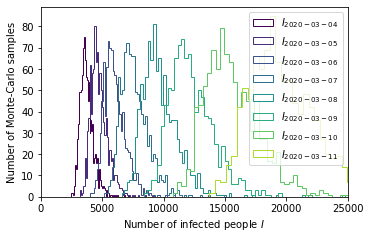

In [44]:
import matplotlib

day_begin = date_today - datetime.timedelta(days = num_days)


plt.figure(figsize=(5.5,3.5))
bins = np.linspace(-0.11, 0.304, 200)
plt.hist(trace.m -mu, bins=bins, 
         label='spread infered from data\nfrom {} to {}'.format(day_begin.isoformat(), date_today.isoformat()))
plt.hist(trace.m*trace.red_factor - mu, bins=bins,
         label='spread assumed for mild social distancing\n $\\approx 0.5 \\cdot \\lambda_{fitted} - \mu $')
plt.hist(trace.m_0 - mu, bins=bins, 
         label='spread assumed for strong social distancing')
plt.xlabel('Effective spread $\lambda - \mu$')
plt.ylabel('Number of Monte-Carlo samples')
plt.legend()
plt.savefig('Distributions_of_m.png', dpi=200)


plt.figure(figsize=(4.5,3.5))
#bins = np.linspace(-0.11, 0.304, 200)
plt.hist((trace.m -mu)*100, bins=50)
plt.xlabel('Effective spread $\lambda - \mu$ (%)\ninferred from data - from {} to {}'.format(day_begin.isoformat(), date_today.isoformat()))
plt.ylabel('Number of Monte-Carlo samples')
plt.tight_layout()
plt.savefig('Distributions_of_fitted_m.png', dpi=200)

plt.figure(figsize=(5.5,3.5))
cmap = matplotlib.cm.get_cmap('viridis')
#cb1 = matplotlib.colorbar.ColorbarBase(plt.gca(), cmap=cmap,
#                                       orientation='vertical')
n_plot = 8
for i in range(num_days-n_plot,num_days):
    day = day_begin + datetime.timedelta(days = i-8)
    f = plt.hist(trace['active_cases_{}'.format(i)], bins=60, histtype='step', 
        color = cmap((i-(num_days-n_plot))/n_plot), label='$I_{{{}}}$'.format(day.isoformat()))

plt.legend()
plt.xlim(0,25000)
plt.xlabel('Number of infected people $I$')
plt.ylabel('Number of Monte-Carlo samples')
plt.savefig('Distributions_of_infected.png', dpi=200)



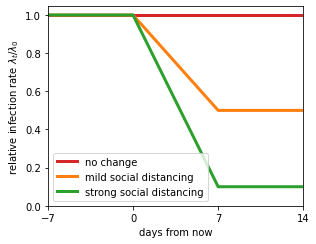

In [67]:
plt.figure(figsize=(4.5,3.5))
m = np.median(trace.m)
decrease_in = 7 #days
time = np.arange(-7,15)
m_correction = (np.clip(time/decrease_in, 0,1))
reduction_fact_strong = 0.9
reduction_fact_mild = 0.5



plt.plot(time, np.ones_like(time), linewidth=3, color='tab:red', 
         label='no change')
plt.plot(time, (1 - m_correction * reduction_fact_mild), linewidth=3, color='tab:orange',
         label='mild social distancing')
plt.plot(time, (1 - m_correction * reduction_fact_strong), linewidth=3, color='tab:green',
         label='strong social distancing')

plt.ylabel("relative infection rate $\lambda_t/\lambda_0$")
plt.xlabel('days from now')
plt.legend(loc='lower left')
plt.xticks([-7,0,7,14])
plt.ylim(0)
plt.xlim(min(time), max(time))
plt.tight_layout()
plt.savefig('evolution_infection_rate.png'.format(lang), dpi=300)



effective m: 1.270 +- 0.007


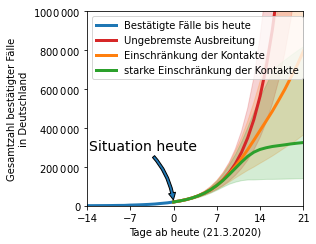

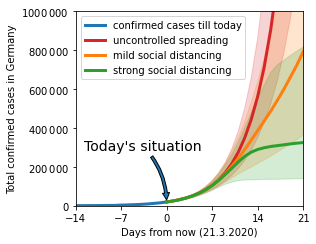

In [73]:
legends_lang = {'german': ['Bestätigte Fälle bis heute', ['Ungebremste Ausbreitung', 
           'Einschränkung der Kontakte', 'starke Einschränkung der Kontakte'],
                           'Tage ab heute (21.3.2020)',
                           'Gesamtzahl bestätigter Fälle\nin Deutschland',
                           "Situation heute"],
            'english': ['confirmed cases till today',['uncontrolled spreading', 'mild social distancing',
                                                          'strong social distancing'],
                            'Days from now (21.3.2020)',
                            'Total confirmed cases in Germany',
                            "Today's situation"]}
obs_cases_labels = ['meas_predict_no_change', 'meas_predict_social_distancing', 
                    'meas_predict_isolation', 'meas_predict_isolation_late']
cases_obs = np.array(confirmed_cases.loc[confirmed_cases['Country/Region'] == 'Germany', '2/25/20':])[0]

def return_obs_cases_future(trace):
  obs_cases_future = dict()
  for label in obs_cases_labels:
    obs_cases_future[label] = []
    for i in range(num_days_to_predict):
      obs_cases_i= trace[label + '_' + str(i)]
      obs_cases_future[label].append(obs_cases_i)
    obs_cases_future[label] = np.array(obs_cases_future[label])
  return obs_cases_future

for lang, legends_list in legends_lang.items():
  plt.figure(figsize=(4.5,3.5))
  colors = ['tab:red', 'tab:orange', "tab:green"]
  time = np.arange(-len(cases_obs)+1, 1)
  plt.plot(time, cases_obs, label=legends_list[0], linewidth=3)
  dict_obsc_cases = return_obs_cases_future(trace)
  for label, color, legend in zip(obs_cases_labels, colors, legends_list[1]):
    time = np.arange(num_days_to_predict+1)
    cases = dict_obsc_cases[label]
    cases = np.concatenate([np.ones((1,cases.shape[1]))*cases_obs[-1], cases], axis=0)
    median = np.median(cases, axis=-1)
    percentiles = np.percentile(cases, q=2.5, axis=-1), np.percentile(cases, q=97.5, axis=-1)
    plt.plot(time, median, color, linewidth=3, label=legend)
    plt.fill_between(time, percentiles[0], percentiles[1], alpha=0.2, color = color)


  plt.xlim(-14, 21)
  plt.ylim(100, 1000000)
  plt.yscale('linear')
  plt.xlabel(legends_list[2])
  plt.ylabel(legends_list[3])
  #plt.locator_params(axis='y', nbins=4)
  plt.legend(loc='upper left')
  plt.xticks([-14,-7,0,7,14,21])
  plt.yticks([0, 200_000,400_000, 600_000, 800_000, 1000_000],
              ['0','$200\,000$','$400\,000$', '$600\,000$','$800\,000$','$1000\,000$'])

  plt.gca().annotate(legends_list[4],
              xy=(0., 20_000), xycoords='data',
              xytext=(0.45, 0.4), textcoords='figure fraction',
              size=14, va="center", ha="center",
              arrowprops=dict(arrowstyle="simple",
                              connectionstyle="arc3,rad=-0.2"),
              )

  plt.tight_layout()
  plt.savefig('cumulative_corona_germany_{}.png'.format(lang), dpi=300)

print('effective m: {:.3f} +- {:.3f}'.format(1+np.median(trace.m - mu), np.std(trace.m - mu)))

# 

# New Section

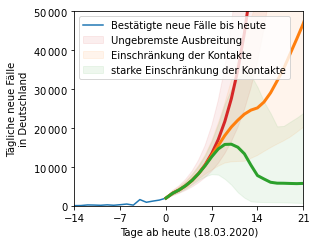

In [0]:
plt.figure(figsize=(4.5,3.5))
legends = ['Ungebremste Ausbreitung', 
           'Einschränkung der Kontakte', 'starke Einschränkung der Kontakte']
colors = ['tab:red', 'tab:orange', "tab:green"]
time = np.arange(-len(cases_obs)+2, 1)
diff_cases_obs = np.diff(cases_obs)
plt.plot(time, diff_cases_obs, label='Bestätigte neue Fälle bis heute')
dict_obsc_cases = return_obs_cases_future(trace)
for label, color, legend in zip(obs_cases_labels, colors, legends):
  time = np.arange(0, num_days_to_predict)
  cases = np.diff(dict_obsc_cases[label], axis=0)
  cases = np.concatenate([np.ones((1,cases.shape[1]))*diff_cases_obs[-1], cases], axis=0)
  median = np.median(cases, axis=-1)
  percentiles = np.percentile(cases, q=2.5, axis=-1), np.percentile(cases, q=97.5, axis=-1)
  plt.plot(time, median, color, linewidth=3)
  plt.fill_between(time, percentiles[0], percentiles[1], alpha=0.08, color = color, label=legend)

plt.ylim(0, 50000)
plt.legend(loc='upper left')

plt.xlabel('Tage ab heute (21.03.2020)')
plt.ylabel('Tägliche neue Fälle\nin Deutschland')
plt.xlim(-14,21)
plt.xticks([-14,-7,0,7,14,21])
plt.yticks([0, 10_000,20_000, 30_000, 40_000, 50_000],['0','$10\,000$','$20\,000$', '$30\,000$', '$40\,000$', '$50\,000$'])
plt.tight_layout()
plt.savefig('new_cases_corona_germany.png', dpi=300)

effective m: 1.270 +- 0.007


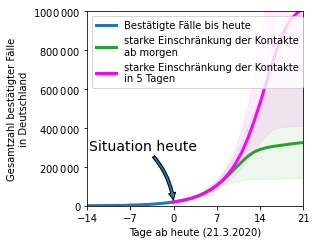

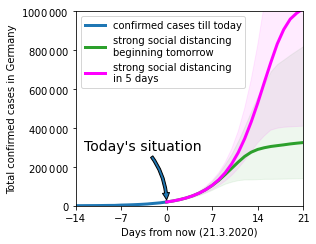

In [72]:

legends_lang = {'german': ['Bestätigte Fälle bis heute', ['starke Einschränkung der Kontakte\nab morgen', 
                           'starke Einschränkung der Kontakte\nin 5 Tagen'],
                           'Tage ab heute (21.3.2020)',
                           'Gesamtzahl bestätigter Fälle\nin Deutschland',
                           "Situation heute"],
                'english': ['confirmed cases till today',['strong social distancing\nbeginning tomorrow', 
                           'strong social distancing\nin 5 days'],
                            'Days from now (21.3.2020)',
                            'Total confirmed cases in Germany',
                            "Today's situation"]}
for lang, legends_list in legends_lang.items():
  plt.figure(figsize=(4.5,3.5))
  colors = ["tab:green", 'fuchsia']
  time = np.arange(-len(cases_obs)+1, 1)
  plt.plot(time, cases_obs, linewidth=3, label=legends_list[0])
  dict_obsc_cases = return_obs_cases_future(trace)
  for label, color, legend in zip(obs_cases_labels[2:], colors, legends_list[1]):
    time = np.arange(num_days_to_predict+1)
    cases = dict_obsc_cases[label]
    cases = np.concatenate([np.ones((1,cases.shape[1]))*cases_obs[-1], cases], axis=0)
    median = np.median(cases, axis=-1)
    percentiles = np.percentile(cases, q=2.5, axis=-1), np.percentile(cases, q=97.5, axis=-1)
    plt.plot(time, median, color, linewidth=3, label=legend)
    plt.fill_between(time, percentiles[0], percentiles[1], alpha=0.08, color = color)

  plt.xlim(-14, 21)
  plt.ylim(0, 1000000)
  plt.yscale('linear')
  plt.xlabel(legends_list[2])
  plt.ylabel(legends_list[3])
  plt.locator_params(axis='y', nbins=4)
  plt.legend(loc='upper left')
  plt.xticks([-14,-7,0,7,14,21])
  plt.yticks([0, 200_000,400_000, 600_000, 800_000, 1000_000],
              ['0','$200\,000$','$400\,000$', '$600\,000$','$800\,000$','$1000\,000$'])

  plt.gca().annotate(legends_list[4],
              xy=(0., 20_000), xycoords='data',
              xytext=(0.45, 0.4), textcoords='figure fraction',
              size=14, va="center", ha="center",
              arrowprops=dict(arrowstyle="simple",
                              connectionstyle="arc3,rad=-0.2"),
              )

  plt.tight_layout()
  plt.savefig('cumulative_corona_germany_late_reaction_{}.png'.format(lang), dpi=300)
  #plt.savefig('cumulative_corona_germany_late_reaction_{}.pdf')

print('effective m: {:.3f} +- {:.3f}'.format(1+np.median(trace.m - mu), np.std(trace.m - mu)))